<a href="https://colab.research.google.com/github/Kamalparanth/ML-concepts/blob/main/pneumothorax_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
TRAINING = True         #@param {type: 'boolean'}
ADD_PRETRAINED = True   #@param {type: 'boolean'}
PROJECT_DIR = './'
weights_dir = PROJECT_DIR + 'weights/'
!mkdir -p {weights_dir}

In [2]:
import os, sys, math, re, gc, random
from time import time, strftime, gmtime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold

if not os.path.isdir('tpu_segmentation'):
    !git clone -q https://github.com/reyvaz/tpu_segmentation.git
    !pip install -qr tpu_segmentation/requirements.txt >/dev/null
    !wget -q https://raw.githubusercontent.com/reyvaz/pneumothorax_detection/master/pneumothorax_utils.py
from tpu_segmentation import *
from pneumothorax_utils import *

start_notebook = time()
print('Notebook started at: ', current_time_str())
print('Tensorflow version: ', tf.__version__)
tf.get_logger().setLevel('ERROR')

Notebook started at:  06:58 AM
Tensorflow version:  2.10.0


In [3]:
#@markdown TPU Distribution Strategy
try: tpu
except:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    else:
        # Default distribution strategy. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.30.66.26:8470


In [4]:
GCS_PATH = 'gs://kds-4d501e469868345dce9c1e6b18bec0954d17ef6c19b8be3ec2a39010'
renew_url = 'https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path'
verify_gcs_path(GCS_PATH, renew_url)

GCS path is valid


In [5]:
IMAGE_SIZE = [1024, 1024] # original size of the x-ray images
N_CLASSES = 1
N_CHANNELS = 1
N_REPLICAS = strategy.num_replicas_in_sync
classes = ['No Disease', 'Disease']

TFRecs_gcs_path = GCS_PATH + '/tfrecs/'
TFRECS_TRAIN_RLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-disease*.tfrec')
TFRECS_TRAIN_NORLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-no-disease*.tfrec')

N_TFRECS_MASK = len(TFRECS_TRAIN_RLE)
N_TFRECS_NOMASK = len(TFRECS_TRAIN_NORLE)

In [6]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(N_TFRECS_MASK))):
    folds.update({fold+1: {'val': idxV, 'train': idxT}})
del fold

def get_fold_file_lists(fold_num, folds=folds, use_unmasked = False):
    fold = folds[fold_num]
    TRAINING_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['val']]

    if use_unmasked:
        TRAINING_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['train']]
        VALIDATION_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['val']]
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

masked_examples = count_data_items(TFRECS_TRAIN_RLE)
unmasked_examples = count_data_items(TFRECS_TRAIN_NORLE)
class_ratio = unmasked_examples/masked_examples

print('Number of MASKED examples for training and validation:   ', masked_examples)
print('Number of NON MASKED examples for training and validation:', unmasked_examples)

Number of MASKED examples for training and validation:    2669
Number of NON MASKED examples for training and validation: 9378


In [7]:
AUTO = tf.data.experimental.AUTOTUNE

def read_tfrecord(example, vars = ('image', 'rle', 'label')):
    features = {
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'image': tf.io.FixedLenFeature([], tf.string), 
        'rle': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        }
    features = {k: features[k] for k in vars}
    example = tf.io.parse_single_example(example, features)
    return [example[var] for var in features]
        
def load_dataset(filenames, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    return dataset.map(read_tfrecord, num_parallel_calls=AUTO)

In [8]:
undersample_filter = lambda L, P: False if L == 0 and tf.random.uniform([]) < P else True
# randomly filters-out examples with label 0. L is the label, P is the rate to exclude

def decode_resize_inputs(inputs, target_size, image_size = IMAGE_SIZE,
                         n_channels = N_CHANNELS, n_classes = N_CLASSES):
    (image_data, rle), args = inputs[:2], inputs[2:]
    image = tf.image.decode_jpeg(image_data, channels=n_channels)
    image = tf.cast(image, tf.float32) / 255.0  
    mask = build_mask_array(rle, image_size)

    if target_size != image_size:
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

    image = tf.reshape(image, [*target_size, n_channels]) 
    mask = tf.reshape(mask, [*target_size, n_classes])
    return (image, mask, *args)

def data_augment(inputs, target_size, 
                 n_channels = N_CHANNELS, n_classes = N_CLASSES, 
                 p1=0.50, p2=0.33, p3=0.33, p4=0.75):
    
    (image, mask, label), args = inputs[:3], inputs[3:]

    if tf.random.uniform([]) < p1:
        image, mask = left_right_flip(image, mask)

    if tf.random.uniform([]) < p2:
        image, mask = random_rotate(image, target_size, n_channels, mask, 
                                    n_classes, 7.)
    elif tf.random.uniform([]) < p2:
        image, mask = random_shear(image, target_size, n_channels, mask)

    if tf.random.uniform([]) < p3: 
        image, mask = random_zoom_out_and_pan(image, target_size, mask, n_channels)
    elif tf.random.uniform([]) < p3*1.5: 
        image, mask = image_mask_zoom_in(image, mask, target_size, label, n_channels)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.7, 1.4)

    if tf.random.uniform([]) < p4: 
        image = coarse_dropout(image, target_size, n_channels, 
                               count_range=(20, 150), m_size = 0.01)
    return (image, mask, label, *args)

def final_reshape(inputs, target_size, target_var, make_rgb, augment,
                  n_channels = N_CHANNELS, n_classes = N_CLASSES):
    '''
    Converts image to 3 channels if specified by `make_rgb`
    Applies augmentations that require 3 channels if requested by `augment`
    Returns the image and one of {mask, label}, as specified by `target_var`
    '''
    (image, mask, label), args = inputs[:3], inputs[3:]

    if make_rgb:
        image = tf.image.grayscale_to_rgb(image)
        n_channels = 3
        if augment:
            image = tf.image.random_hue(image, 0.025)
            image = tf.image.random_saturation(image, 0.6, 1.4)

    image = tf.reshape(image, [*target_size, n_channels]) 

    if target_var == 'mask':
        mask = tf.reshape(mask, [*target_size, n_classes])
        target_var = mask
    elif target_var == 'label': target_var = tf.cast(label, tf.int32)
    else: raise Exception('target_var must be one of \'label\' or \'mask\'')
    return image, target_var

describe_ds = lambda x: print(re.sub('[<>]', '', str(x)))

def print_description(train_ds, val_ds, steps_per_epoch, use_unmasked, 
                      p_undersample, n_train, n_valid):
    describe_ds(train_ds)
    print('Steps per epoch: ', steps_per_epoch)
    approx = 'approx' if p_undersample and p_undersample !=1 and use_unmasked else ''
    print('Num train examples {} {}'.format(n_train, approx))
    print('Num valid examples {}'.format(n_valid))
    return None
     


In [9]:
def get_dataset(filenames, target_size, batch_size, target_var = 'mask',
                make_rgb = True, 
                augment = False,
                cache   = False,
                repeat  = False, 
                shuffle = False,
                ordered = False, 
                drop_remainder = False,
                p_undersample = False):
    dataset = load_dataset(filenames, ordered)
    if p_undersample:
        dataset = dataset.filter(lambda *data: undersample_filter(data[2], p_undersample))
    dataset = dataset.map(lambda *data: decode_resize_inputs(data, target_size), AUTO)
    if augment:
        dataset = dataset.map(lambda *data: data_augment(data, target_size), AUTO)
    dataset = dataset.map(lambda *data: final_reshape(data, target_size, 
                                      target_var, make_rgb, augment), AUTO)
    if cache: dataset = dataset.cache()  
    if repeat: dataset = dataset.repeat() 
    if shuffle: dataset = dataset.shuffle(shuffle, reshuffle_each_iteration=True) 
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_datasets(fold_num, target_size, imgs_per_replica, target_var = 'mask',
             use_unmasked = False, p_undersample = False, cache_val = True, print_descr = True):
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(
        fold_num, use_unmasked=use_unmasked)
    
    train_batch_size = imgs_per_replica * N_REPLICAS

    n_train = count_data_items(TRAINING_FILENAMES)
    n_valid = count_data_items(VALIDATION_FILENAMES)

    if p_undersample and use_unmasked:
        # approx number of examples given random undersampling, val is never undersampled
        n_train = int(n_train * (1-(p_undersample*class_ratio)/(1+class_ratio)))

    train_steps = np.ceil(n_train/train_batch_size).astype(int)
    buffer_size = int(n_train*0.33)

    random.shuffle(TRAINING_FILENAMES)
    train_dataset = get_dataset(TRAINING_FILENAMES, target_size, train_batch_size, 
                                target_var, 
                                augment = True, 
                                repeat = True, 
                                shuffle = buffer_size,
                                drop_remainder=True, 
                                p_undersample = p_undersample)
    
    val_batch_size = 11 * N_REPLICAS # constant validation dataset for dice metric comparison
    # 11 * N_REPLICAS minimizes wasted examples in all folds due to drop_remainder. 

    val_steps = np.ceil(n_valid/val_batch_size).astype(int)
    if target_var == 'mask': val_steps -= 1 # val steps in segmentation due to drop_remainder.

    drop_remainder_val = True if target_var == 'mask' else False

    valid_dataset = get_dataset(VALIDATION_FILENAMES, target_size, val_batch_size, target_var, 
                                cache = cache_val, ordered = True,
                                drop_remainder = drop_remainder_val)
    
    if print_descr:
        print_description(train_dataset, valid_dataset, train_steps, 
                          use_unmasked, p_undersample, n_train, n_valid)
    steps = {'train': train_steps, 'valid': val_steps}
    datasets = {'train': train_dataset, 'valid': valid_dataset}
    return datasets, steps

In [10]:
num_examples = 20 
if num_examples:
    temp_dataset = get_dataset(TFRECS_TRAIN_RLE[:1], target_size=(512, 512), 
                               batch_size=1)
    data_examples = retrieve_examples(temp_dataset, num_examples)
    idx = 0
     

Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Image and Mask



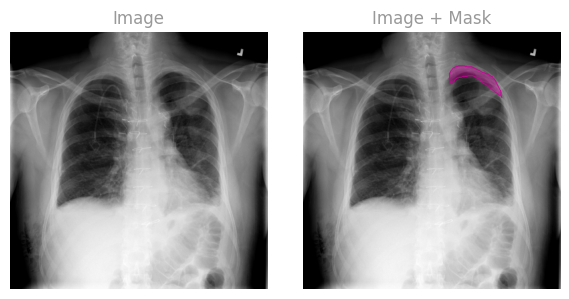



Augmentations



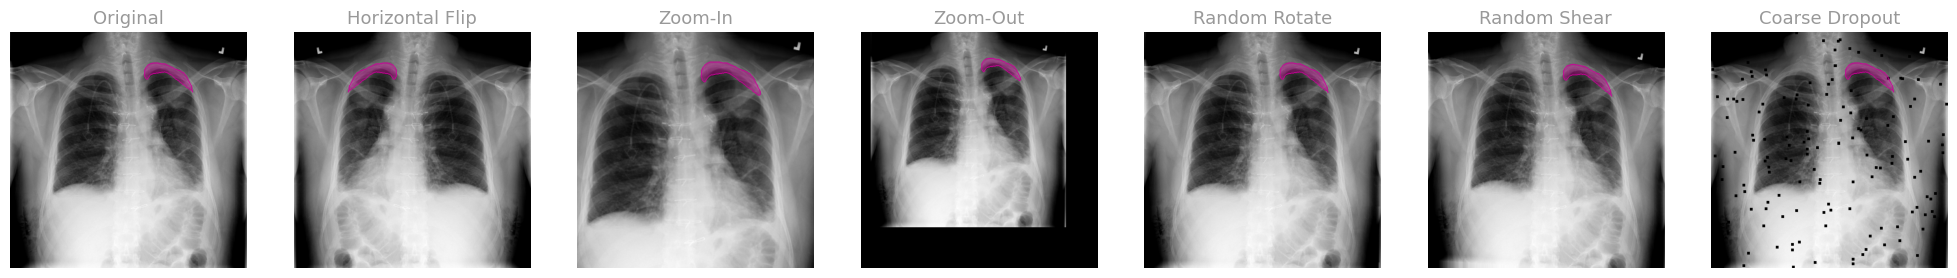

In [11]:
if num_examples:
    idx = idx + 1 if idx < num_examples-1 else 0
    print('Image and Mask\n')
    plot_image_mask(data_examples[idx], height=3)

    print('\n\nAugmentations\n')
    show_augmentations(*data_examples[idx])

Image and Mask



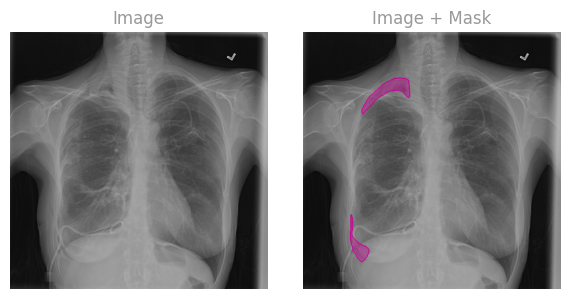



Augmentations



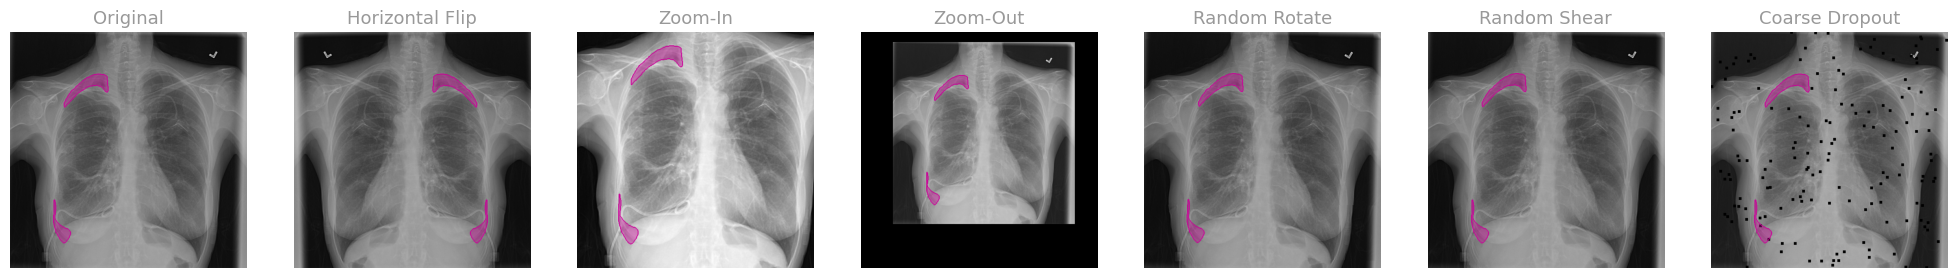

In [12]:
#@markdown  ← reload to show next example
if num_examples:
    idx = idx + 1 if idx < num_examples-1 else 0
    print('Image and Mask\n')
    plot_image_mask(data_examples[idx], height=3)

    print('\n\nAugmentations\n')
    show_augmentations(*data_examples[idx])
     

In [13]:
#@markdown Importing Trained Weights
zip_dest = PROJECT_DIR + 'pneumothorax-fold-1-weights.zip'
if ADD_PRETRAINED: 
    if not os.path.isfile(zip_dest):
        !gdown https://drive.google.com/uc?id=1ptjR8KYSg64CZOvp4vVH3GyTROvjETyk -O {zip_dest}
    !unzip -qn {zip_dest} -d {weights_dir} 
     

In [14]:
#@markdown Weights Management

# Get names of saved weights (if any) in main weights directory
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

!mkdir -p {weights_dir}discarded

weights_metrics = {}
weights_names = {}
for w in saved_weights:
    prefix, sz, _ , metric = w.split('_')
    prefix = '{}_{}'.format(prefix, sz)
    metric_float = float(metric.split('.')[0])*10e-6
    if not prefix in weights_metrics:
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    elif metric_float > weights_metrics[prefix]:
        !mv {weights_dir}{weights_names[prefix]} {weights_dir}discarded/
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    else: 
        !mv {weights_dir}{w} {weights_dir}discarded/

def check_and_save(history, model, fold_num, img_size, metric, metric_abbr = 'acc',
                   current_wname = 'weights.h5', weights_dir=weights_dir):
    current_metric = max(history.history[metric])
    size_str = str(img_size[0]) + 'x' + str(img_size[1])
    prefix = '{}-f{}_{}'.format(model.name.lower(), fold_num, size_str)
    metric_str = str(current_metric*10e4)[:5]
    weights_name = '{}_{}_{}.h5'.format(prefix, metric_abbr, metric_str)
    if not prefix in weights_metrics or current_metric >= weights_metrics[prefix]: 
        weights_names[prefix] = weights_name
        if prefix in weights_metrics:
            !rm -r {weights_dir}{prefix}*
        !cp {current_wname} {weights_dir}{weights_name}
        weights_metrics[prefix] = current_metric
        saved_weights.append(weights_name)
    return None

def create_df_row(w):
    # w: (str) is the filename of the saved weights
    base, size, _, score = w.split('_')
    key_id = '{}_{}'.format(base, size)
    score = float(score.split('.')[0])*10e-6
    size = eval(size.replace('x', ', '))
    base, efn_ver, model_type, fold_num = base.split('-')
    metric = 'accuracy' if 'bin' in model_type else 'avg image-wise dice'
    if 'bin' in model_type: model_type = 'binary' 
    elif 'pp' in model_type: model_type = 'unet++' 
    else: model_type = 'unet' 
    backbone, fold_num = base+efn_ver, int(fold_num[1])
    return [key_id, backbone, fold_num, size, score, metric, model_type, w]

def get_best_weights(df, n_per_fold = 5, sort_by_col = 'score', 
                     group_by_col = 'fold', mode = 'max'):
    m = df.groupby(group_by_col)[sort_by_col]
    m = m.nlargest(n_per_fold) if mode == 'max' else m.nsmallest(n_per_fold)
    try: idxs = [i[1] for i in m.index]
    except: idxs = [i for i in m.index]
    return df.loc[idxs].reset_index(drop=True)
     

In [15]:
#@markdown Existing Weights
col_names = ['key', 'base', 'fold', 'size', 'score', 'metric', 'model_type', 'filename']
bin_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
seg_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 

weights_df = pd.DataFrame(bin_rows + seg_rows, columns = col_names)
display(weights_df[col_names[:7]])

,key,base,fold,size,score,metric,model_type
0,efficientnet-b2-bin-f1_1024x1024,efficientnetb2,1,"(1024, 1024)",0.91873,accuracy,binary
1,efficientnet-b1-bin-f1_512x512,efficientnetb1,1,"(512, 512)",0.90713,accuracy,binary
2,efficientnet-b4-bin-f1_1024x1024,efficientnetb4,1,"(1024, 1024)",0.91708,accuracy,binary
3,efficientnet-b4-bin-f1_512x512,efficientnetb4,1,"(512, 512)",0.91776,accuracy,binary
4,efficientnet-b3-binFT-f1_1024x1024,efficientnetb3,1,"(1024, 1024)",0.92105,accuracy,binary
5,efficientnet-b1-unetpp-f1_512x512,efficientnetb1,1,"(512, 512)",0.56146,avg image-wise dice,unet++
6,efficientnet-b3-unetFT-f1_544x544,efficientnetb3,1,"(544, 544)",0.56986,avg image-wise dice,unet
7,efficientnet-b4-unetFT-f1_544x544,efficientnetb4,1,"(544, 544)",0.56634,avg image-wise dice,unet
8,efficientnet-b4-unetpp-f1_480x480,efficientnetb4,1,"(480, 480)",0.55737,avg image-wise dice,unet++


In [16]:
EPOCHS = 30
use_unmasked = True
p_undersample = 0.50 # rate to exclude x-rays labeled 0

metric_monitor = performance_monitor('val_accuracy', 'max')
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.25)

lr_params =  [3e-4,  3e-4,  1e-6, 2, 4, 8e-1]
lr_sched = lr_schedule_builder(lr_params)
nadam = tf.keras.optimizers.legacy.Nadam() 

In [17]:
folds_to_train = [1] 
dims_to_train = [512] 
efficientnet_versions = [1, 2]

In [18]:
if TRAINING:
    for training_fold in folds_to_train:
        for dim in dims_to_train: 
            target_size = (dim, dim)
            print(hline)
            cache_val, imgs_per_replica = (True, 8) if dim <= 512 else (False, 4)
            datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica , 
                                'label', use_unmasked, p_undersample, cache_val)
            INPUT_SHAPE  = (*target_size, 3)
            for efn_ver in efficientnet_versions:
                base_model = 'EfficientNet-B{}'.format(efn_ver)
                print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                        base_model, training_fold, target_size) + hline)
                
                with strategy.scope():                       
                    model = build_classifier(base_model, N_CLASSES, INPUT_SHAPE, 
                                                name_suffix='-bin')
                    model.compile(optimizer=nadam, loss=loss, metrics=['accuracy', 'AUC']) 

                checkpoint = config_checkpoint(monitor ='val_accuracy', mode = 'max')
                train_begin = time()

                history = model.fit(datasets['train'], steps_per_epoch=steps['train'],
                        epochs = EPOCHS,
                        verbose = 0, 
                        callbacks=[lr_sched, metric_monitor, checkpoint],
                        validation_data = datasets['valid'])
                
                check_and_save(history, model, training_fold, target_size, 'val_accuracy')
                print('Time to train {} epochs: {} (mm:ss)\n'.format(
                    EPOCHS, time_passed(train_begin)))
                
                del model
                K.clear_session()

    del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history
     

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset element_spec=(TensorSpec(shape=(64, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))
Steps per epoch:  92
Num train examples 5884 approx
Num valid examples 2412
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B1 on FOLD 1 with image size (512, 512)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_accuracy improved from -inf to 0.8259
New best at Epoch 002 val_accuracy improved from 0.8259 to 0.8507
New best at Epoch 003 val_accuracy improved from 0.8507 to 0.8673
New best at Epoch 007 val_accuracy improved from 0.8673 to 0.9084

Best at Epoch: 007 loss: 0.48858 accuracy: 0.88706 auc: 0.95033 val_loss: 0.47173 val_accuracy: 0.90837 val_auc: 0.95057
Time to train 30 epochs: 15:16 (mm:ss)

──────────────────────────────────────

In [19]:
EPOCHS = 30
imgs_per_replica = 4
metric_monitor = performance_monitor('val_dice_coef', 'max')

lr_params =  [3e-4,  3e-3,  1e-6, 3, 4, 8e-1] 
lr_sched = lr_schedule_builder(lr_params)

if TRAINING:  
    !pip -q install tensorflow_addons >/dev/null
    import tensorflow_addons as tfa
    radam = tfa.optimizers.RectifiedAdam()

In [20]:
folds_to_train = [1] 
dims_to_train = [480] 
efficientnet_versions = [3]
seg_models = [unet, xnet]
     

In [21]:

if TRAINING:
    for training_fold in folds_to_train:
        for dim in dims_to_train: 
            target_size = (dim, dim)
            print(hline)
            datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 
                                        cache_val = False)
            INPUT_SHAPE  = (*target_size, 3)
            for seg_model in seg_models:
                for efn_ver in efficientnet_versions:
                    backbone_name = 'EfficientNet-B{}'.format(efn_ver)
                    with strategy.scope():
                        model = seg_model(backbone_name, N_CLASSES, INPUT_SHAPE)
                        model.compile(optimizer=radam, loss=bce_dice_loss, 
                                    metrics=[dice_coef, dice_avg]) 

                    print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                                        model.name, training_fold, target_size) + hline)

                    checkpoint = config_checkpoint(monitor ='val_dice_avg', mode = 'max')
                    train_begin = time()
                    history = model.fit(datasets['train'], steps_per_epoch=steps['train'], 
                                    epochs = EPOCHS,
                                    verbose = 0, 
                                    callbacks=[lr_sched, metric_monitor, checkpoint],
                                    validation_data=datasets['valid'])

                    check_and_save(history, model, training_fold, target_size, 'val_dice_avg', 'adice')
                    print('Time to train {} epochs: {} (mm:ss)\n'.format(
                        EPOCHS, time_passed(train_begin)))
                    del model
                    K.clear_session()

    del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset element_spec=(TensorSpec(shape=(32, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 480, 480, 1), dtype=tf.float32, name=None))
Steps per epoch:  67
Num train examples 2133 
Num valid examples 536
44107200/44107200 [==============================] - 0s 0us/step
───────────────────────────────────────────────────────────────────────────────────
Training Efficientnet-B3-Unet on FOLD 1 with image size (480, 480)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_dice_coef improved from -inf to 0.0262
New best at Epoch 002 val_dice_coef improved from 0.0262 to 0.0386
New best at Epoch 003 val_dice_coef improved from 0.0386 to 0.0668
New best at Epoch 005 val_dice_coef improved from 0.0668 to 0.2750
New best at Epoch 006 val_dice_coef improved from 0.2750 to 0.4319
New best at Epoch 007 val_dice_coef improved from 0.

In [22]:
#@markdown Load Trained Model, Assemble Ensemble Functions
!mkdir -p ./weights 

def load_pretrained_model(weights_id, compile_model = True, opt = [], 
                          loss = 'default', metrics = 'default', details = []):
    
    prefix, size = weights_id.split('_')
    size = eval(size.replace('x', ', '))
    base, base_ver, model_type, _  = prefix.split('-')
    wname = weights_names[weights_id]
    weights_path = weights_dir + wname
    
    # Import weights to colab (if elsewhere) to avoid "bad symbol" errors
    if not os.path.isfile('./weights/' + wname):
        !cp {weights_path} ./weights/{wname}
    weights_path = './weights/' + wname

    base_name = base + base_ver

    if 'bin' in model_type: builder = build_classifier
    elif 'unetpp' in model_type: builder = xnet
    elif 'unet' in model_type: builder = unet

    if compile_model:
        if 'bin' in model_type:
            if metrics == 'default': metrics = ['accuracy', 'AUC']
            if loss == 'default': loss = 'binary_crossentropy'
        elif 'unet' in model_type:
            if metrics == 'default': metrics = [dice_coef, dice_avg]
            if loss == 'default': loss = [bce_dice_loss]
        
    with strategy.scope():
        model = builder(base_name, 1, input_shape=(*size, 3), weights = None)
        model.load_weights(weights_path)
        if compile_model:
            model.compile(optimizer=opt, loss=loss, metrics=metrics)
            
    if len(details) > 0: 
        scope = locals()
        return (model, *[eval(d, scope) for d in details])
    else: return model

def determine_outter_size(weights_keys):
    sizes = [eval(k.split('_')[-1].replace('x', ', ')) for k in weights_keys]
    areas = [s[0]*s[1] for s in sizes]
    return sizes[np.argmax(areas)]

def assemble_ensemble(weights_ids, outter_size = 'auto', ensemble_type = 'auto', 
                      metrics = 'default', loss = 'default', details = []):
    if outter_size == 'auto': outter_size = determine_outter_size(weights_ids)
    if ensemble_type == 'auto': 
        ensemble_type = 'segmentation' if 'unet' in weights_ids[0] else 'binary'

    ensemble_outputs = []
    resized_inputs = {}
    with strategy.scope():
        x = L.Input(shape=(*outter_size, 3))
        for i, w in enumerate(weights_ids):
            model, size = load_pretrained_model(w, compile_model = False, details = ['size'])
            model._name = '{}-M{}'.format(model.name, i)
            if size == outter_size:
                model_output = model(x)
            else:
                if not str(size) in resized_inputs: 
                    resized_inputs[str(size)] = tf.image.resize(x, size)
                model_output = model(resized_inputs[str(size)])
                if ensemble_type == 'segmentation':
                    model_output = tf.image.resize(model_output, outter_size)

            ensemble_outputs.append(model_output)

        y = L.Average(name = 'Simple_Average')(ensemble_outputs)

        if metrics == 'default':
            if ensemble_type == 'segmentation': metrics = [dice_coef, dice_avg] 
            else: metrics = ['accuracy', 'AUC']

        if loss == 'default':
            if ensemble_type == 'segmentation': loss = [bce_dice_loss]
            else: loss = 'binary_crossentropy'

        name = '{}_Ensemble'.format(ensemble_type.title())
        ensemble = tf.keras.Model(inputs=x, outputs=y, name=name)
        ensemble.compile(optimizer=[], loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (ensemble, *[eval(d, scope) for d in details])
    else: return ensemble

eval_temp_fix = lambda model, ds: model.evaluate(ds, steps = 1, verbose = 0)[3:]

In [23]:
#@markdown Evaluation Datasets
def data_meta(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, vars = ('img_id', 'label', 'rle')), 
                          num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

def get_eval_datasets(fold_num, target_size = (256, 256), target_var = 'mask', 
                      imgs_per_replica = 8, augment = False, repeat = False):
    '''
    Returns Datasets for evaluation, they are ordered, do not drop remainder. 
    Augmentations and Repeat if requested. 
    '''
    batch_size = imgs_per_replica * N_REPLICAS
    tfrec_lists = get_fold_file_lists(fold_num, use_unmasked = True)
    create_ds = lambda fnames: get_dataset(fnames, target_size, batch_size, target_var, 
                                           augment = augment, repeat = repeat, ordered = True)
    keys = 'train', 'valid'
    datasets = {k: create_ds(tfrec_lists[i]) for i, k in enumerate(keys)}
    counts = {k: count_data_items(tfrec_lists[i]) for i, k in enumerate(keys)}
    min_steps = {k: np.ceil(counts[k]/batch_size).astype(int) for k in counts }
    meta_datasets = {k: data_meta(tfrec_lists[i]) for i, k in enumerate(keys)}
    return datasets, counts, min_steps, meta_datasets

In [24]:
fold_num = 1
_, counts, steps, meta_dsets = get_eval_datasets(fold_num)

In [25]:
#@markdown Build Metadata from TFRecs (Image IDs, Labels, RLEs)
start_retrive_meta = time()
meta_list = []
for item in meta_dsets['valid']:
    meta_list.append([i.numpy() for i in item])

meta_df = pd.DataFrame(meta_list, columns = ['ImageId', 'label', 'rle'])
del meta_list
print('Time to build metadata from tfrecs: {}'.format(time_passed(start_retrive_meta)))

Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Time to build metadata from tfrecs: 00:09


In [26]:

#@markdown Selected Binary Classifiers for Ensemble
bin_df_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
bin_df = pd.DataFrame(bin_df_rows, columns = col_names)

binary_ensemble_size = 4
best_bin = get_best_weights(bin_df, binary_ensemble_size)

best_bin_fold = best_bin[best_bin.fold==fold_num]
bin_keys = best_bin_fold.key.values

display(best_bin_fold[col_names[1:7]])
     

,base,fold,size,score,metric,model_type
0,efficientnetb3,1,"(1024, 1024)",0.92105,accuracy,binary
1,efficientnetb2,1,"(1024, 1024)",0.91873,accuracy,binary
2,efficientnetb4,1,"(512, 512)",0.91776,accuracy,binary
3,efficientnetb4,1,"(1024, 1024)",0.91708,accuracy,binary


In [27]:

model, size = load_pretrained_model(bin_keys[0], details = ['size'])
dsets_repeat = get_eval_datasets(fold_num, size, 'label', repeat = True)[0]
dsets_aug = get_eval_datasets(fold_num, size, 'label', repeat = True, augment = True)[0]
eval_temp_fix(model, dsets_repeat['valid'])

print('\nEvaluating on un-augmented validation data')
_ = model.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on un-augmented train data')
_ = model.evaluate(dsets_repeat['train'], steps = steps['train'])

del model; 
K.clear_session()


Evaluating on un-augmented validation data
38/38 [==============================] - 15s 356ms/step - loss: 0.2731 - accuracy: 0.9206 - auc: 0.9514

Evaluating on un-augmented train data
151/151 [==============================] - 56s 360ms/step - loss: 0.1699 - accuracy: 0.9831 - auc: 0.9980


In [28]:
binary_ensemble, outter_size = assemble_ensemble(bin_keys, details = ['outter_size'])
if outter_size != size:
    dsets_repeat = get_eval_datasets(fold_num, outter_size, 'label', repeat = True)[0]
    dsets_aug = get_eval_datasets(fold_num, outter_size, 'label', repeat = True, augment = True)[0]

eval_temp_fix(binary_ensemble, dsets_repeat['valid'])
binary_ensemble.summary()

Model: "Binary_Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Efficientnet-B3-M0 (Functional  (None, 1)           10785065    ['input_1[0][0]']                
 )                                                                                                
                                                                                    

In [29]:
n_TTA = 5 # number of test time augmentations
print('\nEvaluating on un-augmented validation data')
_ = binary_ensemble.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on augmented validation data')
_ = binary_ensemble.evaluate(dsets_aug['valid'], steps = steps['valid']*n_TTA)


Evaluating on un-augmented validation data
38/38 [==============================] - 32s 796ms/step - loss: 0.2596 - accuracy: 0.9239 - auc: 0.9663

Evaluating on augmented validation data
190/190 [==============================] - 169s 874ms/step - loss: 0.2557 - accuracy: 0.9265 - auc: 0.9679


In [30]:
batch_size = [len(i[0]) for i in dsets_aug['valid'].take(1)][0] 
n_preds_needed = n_TTA*counts['valid']
tta_steps = np.ceil(n_preds_needed/batch_size).astype(int)

preds = binary_ensemble.predict(dsets_aug['valid'], steps = tta_steps, verbose=1)
preds = preds[:n_preds_needed,]
preds = preds.reshape((counts['valid'], n_TTA), order='F')
preds_prob = np.mean(preds, axis = 1)
meta_df['preds_prob'] = preds_prob
del binary_ensemble

Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


189/189 [==============================] - 249s 1s/step


In [31]:
cm_html_str = lambda cm, subtitle: confusion_matrix_html(
    cm, classes, False, subtitle, max_rgb=(179, 0, 89), contrast=.9)

targets, preds_prob = meta_df.label.values, meta_df.preds_prob.values

In [32]:
_, cm, metrics_strings = performance_metrics(targets, preds_prob, report_type = 'total')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(Full Validation Data)')
display(HTML(html_report_base % (cm_string, table_string)))

In [35]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.18 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(High Confidence Thresholds)')
display(HTML(html_report_base % (cm_string, table_string)))

In [36]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.175 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = cm_html_str(cm, '(High Confidence Thresholds)')
display(HTML(html_report_base % (cm_string, table_string)))

In [37]:
#@markdown Segmentation Ensemble Components Info

seg_df_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 
seg_df = pd.DataFrame(seg_df_rows, columns = col_names)

n_top = 4
best_seg = get_best_weights(seg_df, n_top)
best_seg_fold = best_seg[best_seg.fold==fold_num]
seg_keys = best_seg_fold.key.values
display(best_seg_fold[col_names[1:7]])

,base,fold,size,score,metric,model_type
0,efficientnetb3,1,"(544, 544)",0.56986,avg image-wise dice,unet
1,efficientnetb4,1,"(544, 544)",0.56634,avg image-wise dice,unet
2,efficientnetb1,1,"(512, 512)",0.56146,avg image-wise dice,unet++
3,efficientnetb4,1,"(480, 480)",0.55737,avg image-wise dice,unet++


In [38]:
segmentation_ensemble, outter_size = assemble_ensemble(seg_keys, details = ['outter_size'])

n_parts = 3
dsets, counts, steps, _ = get_eval_datasets(fold_num, outter_size, 'mask')
valid_ds_parts = split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)
segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 544, 544, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_1 (TFOpLambda)  (None, 512, 512, 3)  0          ['input_6[0][0]']                
                                                                                                  
 tf.image.resize_3 (TFOpLambda)  (None, 480, 480, 3)  0          ['input_6[0][0]']                
                                                                                                  
 Efficientnet-B1-UnetPP-M2 (Fun  (None, 512, 512, 1)  16013857   ['tf.image.re

In [39]:
meta_dict = meta_df.to_dict()
dice_eval = lambda y, p: dice_coef(tf.cast(y, tf.float32), tf.cast(p, tf.float32))
empty_mask = np.zeros(outter_size, int) 
n_demo =  100 # save some predictions for demo

In [40]:
binary_treshhold = 0.60
thresh_upper = 0.75
thresh_lower = 0.40
min_area = 200 
     

In [41]:
demo_preds = [] 
dices = []
i = 0
start_preds = time()
for p, ds_part in enumerate(valid_ds_parts): 
    print('Predicting and processing part {} of {}'.format(p+1, n_parts))
    preds = segmentation_ensemble.predict(ds_part, verbose = 1)
    preds = np.squeeze(preds)
    gt_masks = [m.numpy().squeeze() for m in ds_part.map(lambda x, y: y).unbatch()]
    print('Shape of predictions part {}: {}\n'.format(p+1, preds.shape))
    for gt_mask, pred in zip(gt_masks, preds):
        instance_id = meta_dict['ImageId'][i]
        if meta_dict['preds_prob'][i]  > binary_treshhold:
            pred_ = pred.copy()
            pred  = (pred > thresh_upper).astype(int)
            if pred.sum() < min_area: pred_mask = empty_mask
            else: 
                pred_mask = (pred_ > thresh_lower).astype(int)
                if len(demo_preds) < n_demo:
                    demo_preds.append([i, gt_mask, pred_mask])
        else: pred_mask = empty_mask
        dices.append(dice_eval(gt_mask, pred_mask).numpy())
        i += 1
    del preds, gt_masks

print('Elapsed time {}'.format(time_passed(start_preds)))
print('Mean Dice:', np.mean(dices))

Predicting and processing part 1 of 3
13/13 [==============================] - 120s 1s/step


Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Shape of predictions part 1: (832, 544, 544)

Predicting and processing part 2 of 3
13/13 [==============================] - 16s 1s/step


Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Shape of predictions part 2: (832, 544, 544)

Predicting and processing part 3 of 3
12/12 [==============================] - 15s 1s/step


Exception ignored in: <function Executor.__del__ at 0x7f2ca3f89940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Shape of predictions part 3: (748, 544, 544)

Elapsed time 04:36
Mean Dice: 0.8689332


In [42]:
#@markdown Plot Mask Ground Truth vs. Prediction
def plot_mask_gt_vs_prediction(pred_demo):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    rgb_colors = {'Ground Truth': (200, 0, 150),
                  'Prediction':   (0, 51, 204)}

    for c, (key, rgb_color) in enumerate(rgb_colors.items()):
        ax = fig.axes[c]
        ax.imshow(pred_demo[0], cmap=plt.cm.bone)
        ax.imshow(contoured_mask(pred_demo[c+1], rgb_color = rgb_color, alpha = 0.2))
        ax.axis('off')
        ax.set_title(key, fontdict={'fontsize': 13})
    plt.show()
    return None

In [43]:
#@markdown Retrieve Images for Demo
ds_part_0 = valid_ds_parts[0].map(lambda x, y: x).unbatch()
masked_idxs = [p[0] for p in demo_preds]
imgs = []
for i, img in enumerate(ds_part_0):
    if i in masked_idxs: 
        imgs.append(img)
        if len(imgs) == n_demo: break

demo_tuples = [(imgs[i], d[1], d[2]) for i, d in enumerate(demo_preds)]

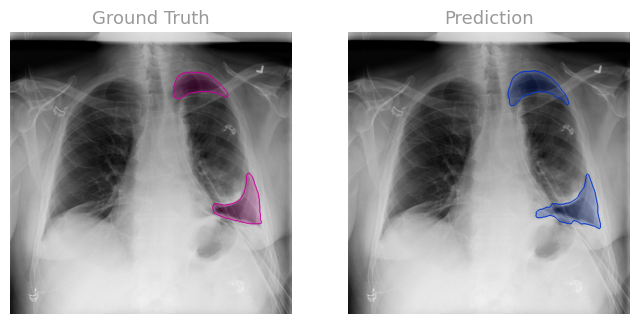

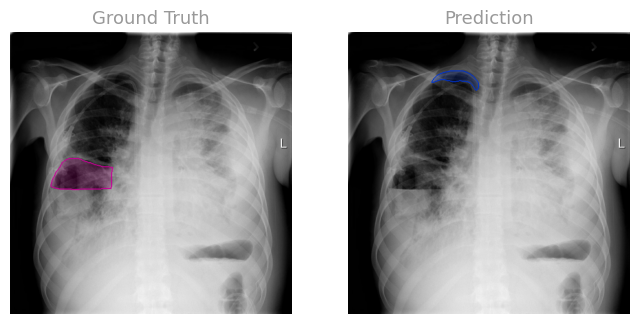

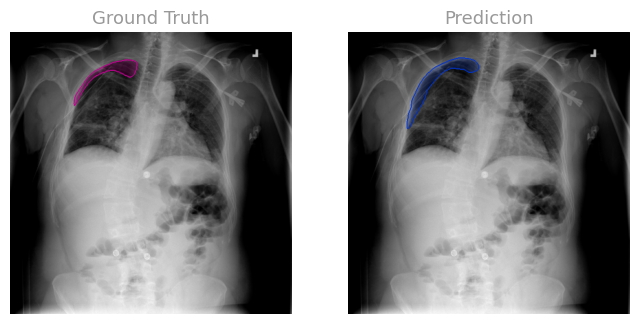

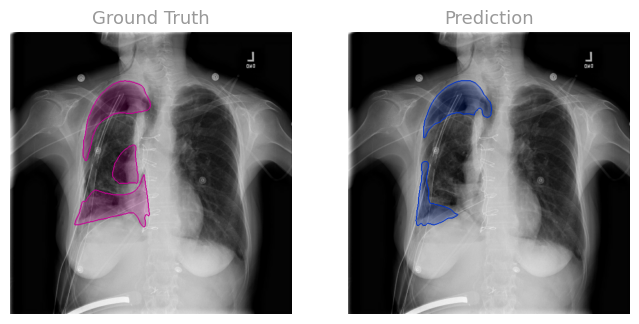

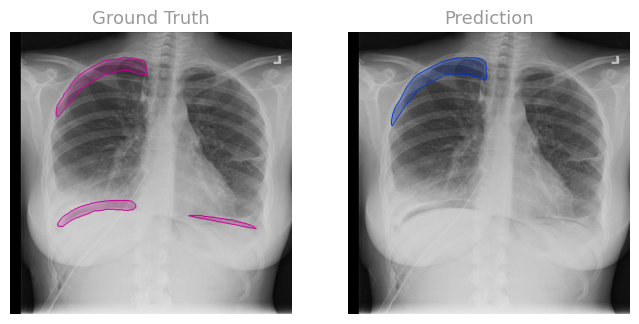

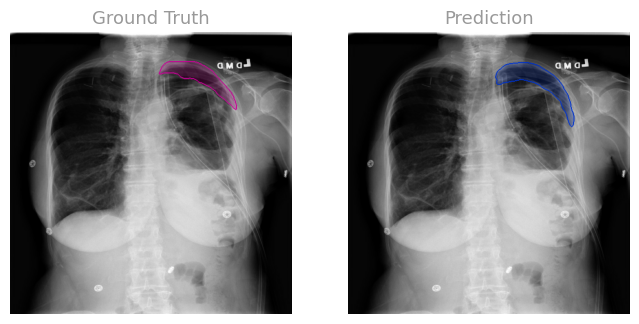

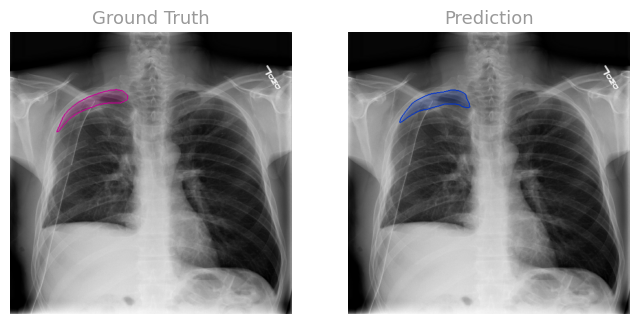

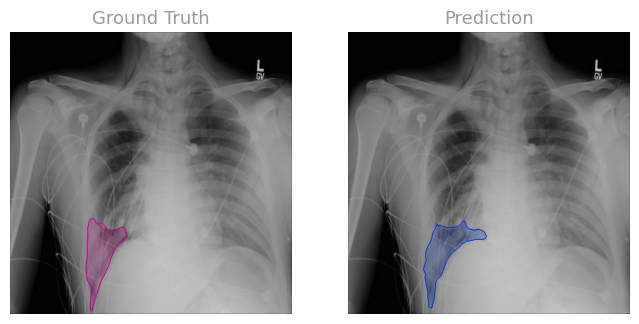

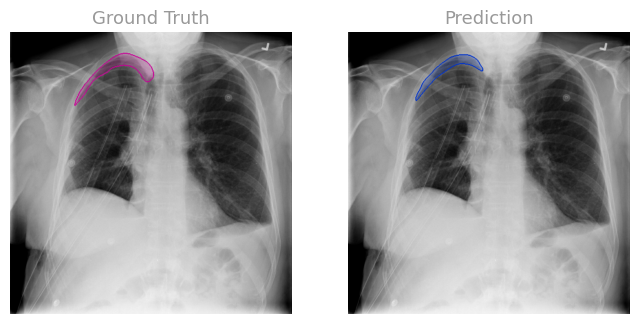

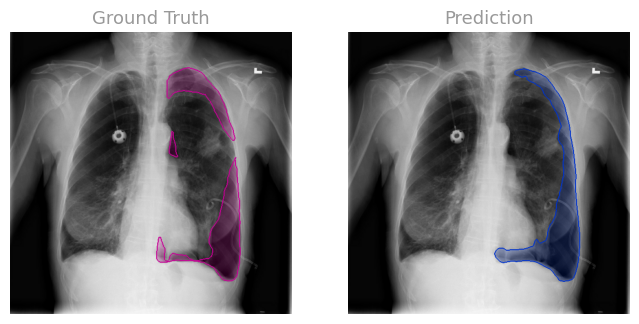

In [44]:

#@markdown Mask Prediciton Examples
for i in np.random.choice(n_demo, 10, replace=False):
    plot_mask_gt_vs_prediction(demo_tuples[i])
    print('\n')

In [46]:
#@markdown Runtime
print('Time to run notebook: ', time_passed(start_notebook))

Time to run notebook:  02:03:25
